In [1]:
import psycopg2

import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns

import os
import matplotlib.pyplot as plt
from datetime import datetime
import re
import boto3
import gc
import warnings
import sys
import time

sns.set()

pd.set_option('max_colwidth', 800)

In [2]:
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues, axi =None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    im = axi.imshow(cm, interpolation='nearest', cmap=cmap)
    axi.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    axi.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    """   
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axi.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout();"""
    return axi

In [3]:
import json 
import pickle

def dump_keras(m,h, mod_path):
    m.save(mod_path+str(".model"))
    history_dict = h.history
    with open(mod_path, 'wb') as file_pi:
        pickle.dump(history_dict, file_pi)

    
    
def load_keras(mod_path):
    model = load_model(mod_path+str(".model"))
    with open(mod_path+str(".history"),'r') as inp:
        history = json.load(inp)
    return model, history

def check_model(path):
    try:
        m, h = load_keras(path)
        return m, h
    except:
        return False, False

## Data improvement
We can now turn to the main function of this notebook; to improve the data quality. We will do this in two steps:
- Correction of crop tags
- Correction of topic tags

In [4]:
try:
    connection = psycopg2.connect(user="postgres",
                                  host="localhost",
                                  port="5432",
                                  database="farmpulse")

    cursor = connection.cursor()

except (Exception, psycopg2.Error) as error :
    print("Error while connecting to PostgreSQL", error)

In [5]:
postgreSQL_select_Query = "select * from call_centre.india_prepped"

cursor.execute(postgreSQL_select_Query)
records = cursor.fetchall()

In [6]:
num_fields = len(cursor.description)
field_names = [i[0] for i in cursor.description]
field_names

['index',
 'crop',
 'created_on',
 'latitude',
 'longitude',
 'query_type',
 'query_text_raw',
 'kcc_answer_raw',
 'state_name',
 'district_name',
 'crop_full',
 'normq']

In [7]:
df = pd.DataFrame(records, columns=field_names)
df.head(3)

,index,crop,created_on,latitude,longitude,query_type,query_text_raw,kcc_answer_raw,state_name,district_name,crop_full,normq
0,1,wheat,2014-12-03 20:45:09,25.77,73.32,plant protection,tell me control of weed of wheat,"2,4d ester 38% ka 500 gm per hactar 500 litar water spray 3035 days par",rajasthan,pali,wheat,"['tell', 'control', 'weed']"
1,2,wheat,2014-12-03 20:46:50,24.93,76.29,fertilizer use and availability,tell me fertilizers in wheat,urea15kgbigh zink sulfet 45 kgbigha,rajasthan,kota,wheat,"['tell', 'fertil']"
2,8,wheat,2014-12-03 20:55:15,27.67,76.36,varieties,tell me late variety of wheat ?,"late variety of wheat raj 3765,raj3777,raj3077",rajasthan,alwar,wheat,"['tell', 'late', 'varieti']"


In [ ]:
# examples of wrongly classified queries
df.loc[[2447554, 3922411]]

In [8]:
print("total dims",df.shape)
original_cropcount = df.crop.value_counts()
print(original_cropcount)

total dims (3822180, 12)
paddy        816846
wheat        655422
cotton       499535
chillies     239008
onion        231355
brinjal      213491
sugarcane    199870
bengal       191470
tomato       186431
groundnut    180435
soybean      167551
potato       134627
maize        106139
Name: crop, dtype: int64


In [9]:
lens = pd.Series([len(i) for i in df.normq])
(lens.value_counts()/lens.value_counts().sum()).head().round(2)

29    0.07
18    0.06
27    0.05
19    0.05
26    0.04
dtype: float64

## Correcting crop tags
Some crops appear to be tagged incorrectly for example; crop A is mentioned in the raw query but a different crop is tagged. Let's see how many of these mismatches there are, using cotton as an example:

In [10]:
def animate_data(dfin):
    """re-animate df for use"""
    if not isinstance(dfin.normq[0], list):
        dfin['normq'] = [eval(i) for i in dfin.normq]
    dfin['Qstr'] = [" ".join(i) for i in dfin.normq]
    dfin['query_text_raw'] = dfin.query_text_raw.str.lower()
    # dfin = dfin.drop('index')

    return dfin

def correct_crops(dfin):
    """correct crop categories based on finding the crop name in the query string"""
    for cropname in dfin.crop.value_counts().index[0:10]:
        dfin[cropname] = dfin.query_text_raw.str.contains(cropname) # create bool
        before = dfin[(dfin.crop!=cropname) & (dfin[cropname].values==True)].shape[0] #N mismatches
        dfin.loc[dfin[(dfin.crop!=cropname) & (dfin[cropname].values==True)].index, 'crop'] = cropname
        dfin.drop(cropname, axis=1, inplace=True)
        print("corrected {} for {}".format(before, cropname))
    return(dfin)

In [11]:
df = animate_data(df)

In [12]:
# demo that some names are mismatched
df['cotton'] = df.query_text_raw.str.contains("cotton")
print(df.cotton.sum(),"cotton mentioned in query ")
print(df[df.crop=='cotton'].shape[0], "cotton tagged as *crop*")
print( df[(df.crop!='cotton') & (df.cotton==True)].shape[0] , 'cotton mismatches (cotton in string but other crop tagged)')

343211 cotton mentioned in query 
499535 cotton tagged as *crop*
7517 cotton mismatches (cotton in string but other crop tagged)


In [13]:
# do something about red cotton bug
df[(df.crop!='cotton') & (df.cotton==True)][['query_text_raw','crop', 'index']].head() 

,query_text_raw,crop,index
23565,red cotton bug,brinjal,144010
23646,red cotton bug,brinjal,144808
24542,red cotton bug,brinjal,152483
30083,"q. aphid, jassid white fly attack of cotton?",paddy,169409
31575,"control of bollworms, fruit shoot borer of cotton, okra ?",bengal,171588


In [14]:
# fix all names
df = correct_crops(df)

corrected 5917 for paddy
corrected 15546 for wheat
corrected 7933 for cotton
corrected 605 for chillies
corrected 3322 for onion
corrected 1715 for brinjal
corrected 3106 for sugarcane
corrected 388 for bengal
corrected 3604 for tomato
corrected 1613 for groundnut


In [15]:
print(np.sum(np.absolute(df.crop.value_counts() - original_cropcount)), "alterations")
df.crop.value_counts() - original_cropcount

38556 alterations


paddy       -10771
wheat         9372
cotton        5110
chillies     -1790
onion         1768
brinjal       -119
sugarcane     -434
bengal       -1900
tomato        2239
groundnut      789
soybean      -1599
potato       -1665
maize        -1000
Name: crop, dtype: int64

In [16]:
unique_crops = str("_".join(df.crop.unique() )) + str("_")
unique_crops

'wheat_onion_maize_tomato_bengal_cotton_brinjal_potato_chillies_groundnut_sugarcane_paddy_soybean_'

## Fixing query types
We can also attempt to re-tag the queries. This is slightly more complex as we want to analyse the content of the call records and assign a category based on that content.

We do have some constraints to account for when deciding our strategy:

- Constraint 1: documents are ultra-short
  - more than half our documents consist of less than 3 words, this will severely hamper traditional statistical approaches (such as LDA) due to sparseness
- Constraint 2: must be humanly intelligible
  - As with most topic models, we want our labels to be humanly intelligible so we can assign the right content for our P^3 solution, this means we will have to enforce topic names at some point.

Given the above constraints, I have decided on a word2vec approach. The plan is to generate dense vectors describing the dataset, and then use the existing topic tags in a supervised classification task to re-tag all the queries. This approach assumes the majority of topic tags are correct. We can assess this assumption by looking at the agreement between the "predicted" tags and the original tags, as well as PCA analysis of the original and new tags (we'd expect to see tighter clustering with the new tags).

Note that the short doc length may also negatively impact the W2V model (through reduced context windows) but we would still expect this to be better than an LDA model, keyword tagging, or biterm topic modelling due to the ability of W2V to easily understand synonyms, spelling errors, and word relations. Additionally, another advantage to this approach is we can use existing topic labels, rather than having to derive new ones by hand.

Overall, we expect this approach to yield two benefits:
- Correcting out-right error by majority vote
- Making topic tagging more uniform across states/call centre workers (note that even if this is independent of the above we would still expect improvements in our downstream modelling)

Let's now turn to preparing the datset.

In [17]:
def prepare_texts(dataf, crop_sel='paddy'):
    """Prepare texts, tags (classes) and a small dataframe from raw data"""
    d_sub = dataf.loc[df.crop==crop_sel,:] 
    d_sub.dropna(inplace=True)
    d_sub = d_sub[d_sub.query_type!='nan']

    # take only the top 15 as categories. Set everything else to Misc (this affects only a small number of queries)
    top10 = d_sub.query_type.value_counts().index[0:15]
    ind = d_sub[~d_sub.query_type.isin(top10)].index
    d_sub.loc[ind, 'query_type'] = "Misc"

    d_sub.reset_index(inplace=True, drop=True)
    texts = d_sub.normq #list(filter(lambda x: x != "cotton",d.normQ)) #filter out crop name
    tags = d_sub.query_type
    return texts, tags, d_sub[['crop','created_on','latitude','longitude','query_type','state_name','district_name','query_text_raw','kcc_answer_raw']]

In [18]:
crop_selected = 'cotton'

In [19]:
texts, tags, d = prepare_texts(df, crop_sel=crop_selected)


#texts, tags, d = prepare_texts(df.drop_duplicates('query_text_raw'), crop_sel=crop_selected)

<ipython-input-17-317c0a893349>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_sub.dropna(inplace=True)


In [20]:
tags.value_counts()

plant protection                    230637
fertilizer use and availability      52535
market information                   48448
varieties                            27769
cultural practices                   27620
nutrient management                  24818
biopesticides and biofertilizers     24661
seeds                                24441
field preparation                    13523
agriculture mechanization             9516
weather                               8200
Misc                                  4032
weed management                       3579
government schemes                    1965
sowing time and weather               1664
water management                      1237
Name: query_type, dtype: int64

In [21]:
print(len(texts), "documents prepared for model")
# print(len(resampled), "subsample documents prepared for model")

504645 documents prepared for model


In [22]:
from gensim.models import Word2Vec

# vocab attribute no longer exists, use index_to_key instead
word2vec = Word2Vec(texts, min_count=100, workers=4)
vocabulary = word2vec.wv.index_to_key
word_vectors  = word2vec.wv

In [23]:
wcount = {}
for item in vocabulary:
    wcount[item] = word_vectors.get_vecattr(item, "count")

wcount = pd.DataFrame({"Word":list(wcount.keys()), "Count": list(wcount.values()), "vec":[word_vectors[i] for i in wcount.keys()]}).sort_values('Count', ascending=False)
vec_samp = [pd.DataFrame(word_vectors[i]) for i in wcount.Word.values]

In [24]:
wcount.drop('vec',axis=1).head(10)

,Word,Count
0,control,126984
1,ask,103424
2,tell,52677
3,attack,51702
4,varieti,51041
5,market,47906
6,rate,40377
7,pest,39781
8,fertil,39527
9,white,34062


In [25]:
wcount.loc[[23,10]]

,Word,Count,vec
23,aphid,11882,"[-0.025172597, -0.037374355, 0.6595895, -0.44314602, -0.45117572, -0.30575278, -1.0436527, 0.7722288, 0.050430093, -0.044159546, -0.33025658, -0.11083333, -0.7408937, 0.07222487, 0.0361686, -0.13439475, 0.4944793, -0.19296508, 0.44193166, -0.50260174, -0.56173897, -0.30205554, 0.30775926, -0.10165524, -0.15914571, 0.37360486, -0.7787167, 1.2308394, -0.15649603, 0.15642174, -0.1879501, 0.26352608, 0.14799146, 0.12475448, -0.3264827, -0.6510141, 0.03444734, -0.7651048, -0.7268694, 0.31682655, -0.7125365, 0.9237345, -0.39320257, -0.06390218, -0.44032806, -0.9212346, 0.9531386, 0.11790121, -0.42751133, 0.65319777, 0.7763907, 0.38369474, 0.65239906, 0.32027286, -0.42433774, -0.35961464, -0.52315396, 0.2736488, 1.1894058, -0.5549046, -0.49982288, 0.09984886, 0.17475401, 0.34797004, -0.088114..."
10,suck,32898,"[-0.60598236, 0.85091084, 0.28121248, -0.6433062, -0.54792297, 0.035539895, -1.5537544, 0.3202514, 0.481431, 0.608041, 0.55222344, -0.0069546695, 0.022001421, -0.65013444, -0.004049512, -0.41864234, -0.052123126, -0.91592777, 0.18315788, -1.0082911, -1.2363553, -0.17819121, 0.90714675, 0.9449598, -0.6100653, 0.422826, -0.5568041, -0.0982446, -0.34099776, 0.2728858, -0.094290555, -0.08761188, 0.50462973, 0.5279792, 0.13737094, -0.16927783, -0.6980459, -0.93851244, -0.26010278, -0.044245202, -0.5000321, 0.3507828, -1.3458762, 0.9720115, -0.5716726, -0.4882267, 0.490592, -0.6575009, -1.162707, 0.32503933, 0.63653886, -0.0805447, -0.29928872, 0.7706525, -0.6556398, -0.67304885, -0.09366115, -0.06099696, -0.12895659, -0.7150207, -1.1695598, -0.1515564, 0.03189621, -5.9505328e-05, -0.5308616..."


In [26]:
print("Odd one out:",word_vectors.doesnt_match("market rate attack price".split()))

Odd one out: attack


In [27]:
samps = pd.DataFrame({"Word":vocabulary, "Vector":word_vectors})

In [28]:
samps.head()

,Word,Vector
0,control,"[[0.54141885, -0.7824243, 0.8307869, 0.005294428, -1.2326324, 0.7480234, 0.426122, 0.09552996, -0.16673155, 0.61942947, 0.19314367, 0.08478196, -0.6930486, -0.5383454, -0.36710018, -1.0754833, -0.3202275, 0.73446774, -0.84598404, -0.3472461, -1.1198132, 0.1791401, 0.6120046, 1.1112317, -0.2663255, 0.4274656, 0.24012606, 0.9632108, -0.5834124, -1.1645764, -0.076799974, -0.17857814, 0.73489517, -0.884387, 0.1472151, 0.3568925, 0.51201934, -1.2128617, -0.61565995, 0.57196283, -0.93688065, 0.57070786, -0.7200294, 0.7550346, -0.5350605, -0.34537533, 0.8112409, 0.3009768, -0.6831167, -0.42051682, -0.30124447, 0.5566455, -0.3198232, -0.45375627, 0.32883832, -0.29164138, 0.5136742, 0.23177621, -0.30062783, 0.36844197, 0.13897568, -0.027850254, -0.3725447, 0.10659772, 0.5419004, 0.09182887, -0...."
1,ask,"[[0.54141885, -0.7824243, 0.8307869, 0.005294428, -1.2326324, 0.7480234, 0.426122, 0.09552996, -0.16673155, 0.61942947, 0.19314367, 0.08478196, -0.6930486, -0.5383454, -0.36710018, -1.0754833, -0.3202275, 0.73446774, -0.84598404, -0.3472461, -1.1198132, 0.1791401, 0.6120046, 1.1112317, -0.2663255, 0.4274656, 0.24012606, 0.9632108, -0.5834124, -1.1645764, -0.076799974, -0.17857814, 0.73489517, -0.884387, 0.1472151, 0.3568925, 0.51201934, -1.2128617, -0.61565995, 0.57196283, -0.93688065, 0.57070786, -0.7200294, 0.7550346, -0.5350605, -0.34537533, 0.8112409, 0.3009768, -0.6831167, -0.42051682, -0.30124447, 0.5566455, -0.3198232, -0.45375627, 0.32883832, -0.29164138, 0.5136742, 0.23177621, -0.30062783, 0.36844197, 0.13897568, -0.027850254, -0.3725447, 0.10659772, 0.5419004, 0.09182887, -0...."
2,tell,"[[0.54141885, -0.7824243, 0.8307869, 0.005294428, -1.2326324, 0.7480234, 0.426122, 0.09552996, -0.16673155, 0.61942947, 0.19314367, 0.08478196, -0.6930486, -0.5383454, -0.36710018, -1.0754833, -0.3202275, 0.73446774, -0.84598404, -0.3472461, -1.1198132, 0.1791401, 0.6120046, 1.1112317, -0.2663255, 0.4274656, 0.24012606, 0.9632108, -0.5834124, -1.1645764, -0.076799974, -0.17857814, 0.73489517, -0.884387, 0.1472151, 0.3568925, 0.51201934, -1.2128617, -0.61565995, 0.57196283, -0.93688065, 0.57070786, -0.7200294, 0.7550346, -0.5350605, -0.34537533, 0.8112409, 0.3009768, -0.6831167, -0.42051682, -0.30124447, 0.5566455, -0.3198232, -0.45375627, 0.32883832, -0.29164138, 0.5136742, 0.23177621, -0.30062783, 0.36844197, 0.13897568, -0.027850254, -0.3725447, 0.10659772, 0.5419004, 0.09182887, -0...."
3,attack,"[[0.54141885, -0.7824243, 0.8307869, 0.005294428, -1.2326324, 0.7480234, 0.426122, 0.09552996, -0.16673155, 0.61942947, 0.19314367, 0.08478196, -0.6930486, -0.5383454, -0.36710018, -1.0754833, -0.3202275, 0.73446774, -0.84598404, -0.3472461, -1.1198132, 0.1791401, 0.6120046, 1.1112317, -0.2663255, 0.4274656, 0.24012606, 0.9632108, -0.5834124, -1.1645764, -0.076799974, -0.17857814, 0.73489517, -0.884387, 0.1472151, 0.3568925, 0.51201934, -1.2128617, -0.61565995, 0.57196283, -0.93688065, 0.57070786, -0.7200294, 0.7550346, -0.5350605, -0.34537533, 0.8112409, 0.3009768, -0.6831167, -0.42051682, -0.30124447, 0.5566455, -0.3198232, -0.45375627, 0.32883832, -0.29164138, 0.5136742, 0.23177621, -0.30062783, 0.36844197, 0.13897568, -0.027850254, -0.3725447, 0.10659772, 0.5419004, 0.09182887, -0...."
4,varieti,"[[0.54141885, -0.7824243, 0.8307869, 0.005294428, -1.2326324, 0.7480234, 0.426122, 0.09552996, -0.16673155, 0.61942947, 0.19314367, 0.08478196, -0.6930486, -0.5383454, -0.36710018, -1.0754833, -0.3202275, 0.73446774, -0.84598404, -0.3472461, -1.1198132, 0.1791401, 0.6120046, 1.1112317, -0.2663255, 0.4274656, 0.24012606, 0.9632108, -0.5834124, -1.1645764, -0.076799974, -0.17857814, 0.73489517, -0.884387, 0.1472151, 0.3568925, 0.51201934, -1.2128617, -0.61565995, 0.57196283, -0.93688065, 0.57070786, -0.7200294, 0.7550346, -0.5350605, -0.34537533, 0.8112409, 0.3009768, -0.6831167, -0.42051682, -0.30124447, 0.5566455, -0.3198232, -0.45375627, 0.32883832, -0.29164138, 0.5136742, 0.23177621, -0.30062783, 0.36844197, 0.13897568, -0.0

In [30]:
keys = ['market','pest','nutrient','fertil','control','varieti','weed']
for i in keys:
    print(i, end=" - ")
    for a, b in word_vectors.similar_by_word(i, topn=6):
        print(a, round(b,3), end=", ")
    print("\n")

market - mkt 0.785, villupuram 0.779, konganapuram 0.779, msp 0.769, gangav 0.763, quintal 0.707, 

pest - larva 0.607, whitefli 0.598, insect 0.583, thrip 0.537, fungu 0.536, aphid 0.518, 

nutrient - micro 0.661, magnesium 0.54, leafhopp 0.54, weedicid 0.529, grow 0.525, basal 0.52, 

fertil - fertilis 0.823, fertliz 0.76, fert 0.675, ferti 0.671, yellowingfertil 0.667, urea 0.658, 

control - cotrol 0.554, contorl 0.494, cottn 0.488, nformat 0.479, problem 0.479, manag 0.463, 

varieti - variti 0.838, vareiti 0.827, verieti 0.786, varaiti 0.784, veriti 0.748, varitey 0.746, 

weed - parawilt 0.703, anthracnos 0.681, marodia 0.681, mealybug 0.651, termit 0.646, marodiya 0.625, 



In [29]:
keys2 = ['control','ask','tell','attack','varieti']
for i in keys2:
    print(i, end=" - ")
    for a, b in word_vectors.similar_by_word(i, topn=6):
        print(a, round(b,3), end=", ")
    print("\n")

control - contorl 0.503, cotrol 0.494, reagard 0.463, attack 0.449, nformat 0.441, cottn 0.437, 

ask - iyal 0.472, suggest 0.471, enquir 0.383, chilli 0.322, bollworm 0.29, aphid 0.289, 

tell - tel 0.791, moong 0.435, cottan 0.384, deemak 0.372, cotten 0.365, cooton 0.351, 

attack - attck 0.732, damag 0.622, baout 0.523, contorl 0.511, attak 0.505, manag 0.497, 

varieti - variti 0.832, vareiti 0.82, varaiti 0.778, verieti 0.741, varitey 0.73, veriti 0.728, 



In [30]:
def get_w2v_features(w2v_model, text_sentence):
    """generate vector from texts"""
    index2word_set = set(w2v_model.wv.index_to_key)  # words known to model
    featureVec = np.zeros(w2v_model.vector_size, dtype="float32")

    # counter
    nwords = 0
    # w2v summer
    for word in text_sentence:
        if word in index2word_set: 
            featureVec = np.add(featureVec, w2v_model.wv[word])
            nwords += 1.

    if nwords > 0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec

In [31]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    wv_features = pd.DataFrame(list(map(lambda sen_group:
                                          get_w2v_features(word2vec, sen_group),
                                          texts)))

wv_features.columns = ["f{}".format(n) for n in range(len(wv_features.columns))]

## Logistic Reg

In [32]:
from joblib import dump, load
from sklearn.metrics import f1_score

def correct_tags_logr(target_var, predictor_vars, frac=0.7, overwrite=True):
    """fit a multi-class  logistic regression and return predicted labels
    params:
        target_var: y
        predictor_vars = X
        frac = . train test split
        overwrite = whether to overwrite existing, True will retrain and overwrite, False will try to load, and any other value will retrain but NOT overwrite"""
    from sklearn.linear_model import LogisticRegression 

    target_train =  target_var.sample(frac=frac).index
    target_test = target_var.drop(target_train).index
    path = './data/logr.joblib'
    
    if os.path.exists(path) and overwrite is False:
        clf = load(path) 
        print("reloaded from ",path)
    else:
        print("training new model...")
        clf = LogisticRegression(random_state=11, max_iter=250, solver='lbfgs',multi_class='ovr',n_jobs=4, penalty='l2', class_weight="balanced", C=0.1)
        clf.fit(predictor_vars.loc[target_train], target_var.loc[target_train])
        if overwrite is True:
            dump(clf, path) 
        
    f = f1_score(clf.predict( predictor_vars.loc[target_test]), target_var.loc[target_test], average='macro')
    fw = f1_score(clf.predict( predictor_vars.loc[target_test]), target_var.loc[target_test], average='weighted')
    a = clf.score(predictor_vars.loc[target_test], target_var.loc[target_test])*100
    
    print(round(f, 2), "F1 Macro")
    print(round(fw, 2), "F1 Weighted")
    print(round(a), "% match")
    
    predicted_labels = clf.predict(predictor_vars)
    
    return clf

In [33]:
random_guess = correct_tags_logr(target_var= tags, predictor_vars = wv_features.sample(frac=1.0).reset_index(drop=True) , frac=0.1 )

training new model...
0.02 F1 Macro
0.02 F1 Weighted
1 % match


In [34]:
# real use
newlabel_logr = correct_tags_logr(target_var= tags, predictor_vars = wv_features , frac=0.33 ,overwrite=False)
newlabel_logr

reloaded from  ./data/logr.joblib
0.03 F1 Macro
0.03 F1 Weighted
2 % match


LogisticRegression(C=0.1, class_weight='balanced', max_iter=250,
                   multi_class='ovr', n_jobs=4, random_state=11)

In [35]:
gc.collect()

44

## ANN

In [36]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model

import os
import tempfile

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [37]:
from tensorflow.keras import metrics

In [38]:
def make_metrics(): 
    
    M = [
        keras.metrics.CategoricalAccuracy(name='accuracy'),
        keras.metrics.TopKCategoricalAccuracy(name='kacc',k=5),
        keras.metrics.TruePositives(name='tp'),
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.TrueNegatives(name='tn'),
        keras.metrics.FalseNegatives(name='fn'), 
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
        ]
    return M

METRICS = make_metrics()

In [39]:
num_class = len(tags.value_counts())
num_class

16

In [40]:
from tensorflow.keras.utils import to_categorical

tags_flat = to_categorical(tags.astype('category').cat.codes)
tags_coded = tags.astype('category').cat.codes

train_ind =  wv_features.sample(frac=0.8).index
test_ind = wv_features.drop(train_ind).index

In [41]:
def make_model(metrics = METRICS, output_bias=None):
    
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    
    model = keras.Sequential([
          keras.layers.Dense(
              32, activation='tanh',
              input_shape=(100,)),
          keras.layers.Dropout(0.15),
          keras.layers.Dense(num_class, activation='sigmoid',
                             bias_initializer=output_bias),
      ])

    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=metrics)

    return model

In [42]:
EPOCHS = 35
BATCH_SIZE = 4096

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_kacc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [43]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                3232      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
Total params: 3,760
Trainable params: 3,760
Non-trainable params: 0
_________________________________________________________________


In [44]:
model.predict(wv_features[:1])

array([[0.4335097 , 0.47490144, 0.36040556, 0.51733595, 0.3515221 ,
        0.7251165 , 0.37194198, 0.4979354 , 0.3537897 , 0.50314635,
        0.5036452 , 0.3852834 , 0.42493102, 0.41745067, 0.5203827 ,
        0.6098455 ]], dtype=float32)

In [45]:
pd.concat([tags, tags_coded],axis=1).drop_duplicates()

,query_type,0
0,market information,7
12,fertilizer use and availability,4
16,cultural practices,3
26,field preparation,5
41,plant protection,9
72,Misc,0
81,agriculture mechanization,1
94,biopesticides and biofertilizers,2
102,government schemes,6
106,weather,14


In [46]:
tags[0],tags_coded[0], tags_flat[0]

('market information',
 7,
 array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32))

In [47]:
results = model.evaluate(wv_features[0:100000], tags_flat[0:100000], batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 2.7855


In [48]:
label_codes = pd.concat([tags, tags_coded],axis=1).drop_duplicates()
label_codes.columns = ['label','code']
label_codes.head(3)

,label,code
0,market information,7
12,fertilizer use and availability,4
16,cultural practices,3


In [49]:
initial_bias =  (tags.value_counts()/tags.value_counts().mean())
initial_bias = pd.DataFrame(initial_bias)
initial_bias.columns=['bias']

In [50]:
initial_bias = initial_bias.merge(label_codes, left_index=True, right_on='label').sort_values('code')

In [51]:
initial_bias['bias'] = np.log(initial_bias.bias.values)

In [52]:
initial_bias

,bias,label,code
72,-2.057004,Misc,0
81,-1.198292,agriculture mechanization,1
94,-0.246043,biopesticides and biofertilizers,2
16,-0.132726,cultural practices,3
12,0.510213,fertilizer use and availability,4
26,-0.846875,field preparation,5
102,-2.775774,government schemes,6
0,0.429225,market information,7
362,-0.239697,nutrient management,8
41,1.989579,plant protection,9


In [53]:
model = make_model(output_bias = initial_bias.bias.values )
model.predict(wv_features[0:1])

array([[0.16110748, 0.26105386, 0.46604794, 0.53058064, 0.6064909 ,
        0.16706175, 0.06870803, 0.7022243 , 0.52825314, 0.8959023 ,
        0.62796086, 0.06455946, 0.6092506 , 0.04834062, 0.18981135,
        0.08249161]], dtype=float32)

With this initialization the initial loss per class should be approximately:

$-p_0 log(p_0) - (1-p_0)log(1-p_0) = 3.1 $

In [54]:
results = model.evaluate(wv_features, tags_flat, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.9223


We can see the initial loss is now substantially lower.

This way the model doesn't need to spend the first few epochs just learning that positive examples are unlikely. This also makes it easier to read plots of the loss during training.

Let's confirm:

In [55]:
initial_weights = './data/initial_weights'
model.save_weights(initial_weights)

In [56]:
xtrain = wv_features.loc[train_ind]
ytrain = tags_flat[train_ind]

xval = wv_features.loc[test_ind]
yval = tags_flat[test_ind]

In [57]:
modela = make_model()
#modela.load_weights(initial_weights)
modela.layers[-1].bias.assign(np.ones(16)) # zero bias
zero_bias_history = modela.fit(
    xtrain,
    ytrain,
    batch_size=256,
    epochs=25,
    validation_data=(xval, yval), 
    verbose=0)

In [58]:
modelb = make_model()
modelb.load_weights(initial_weights)
careful_bias_history = modelb.fit(
    xtrain,
    ytrain,
    batch_size=256,
    epochs=25,
    validation_data=(xval, yval), 
    verbose=0)

In [59]:
def plot_loss(history, label, n ,var='loss'):
  # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history[var],
               color=n, label='Train '+label)
    plt.semilogy(history.epoch,  history.history["val_{}".format(var)],
          color=n, label='Val '+label,
          linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel(var)
    plt.xlim(0,5)
  
    plt.legend()

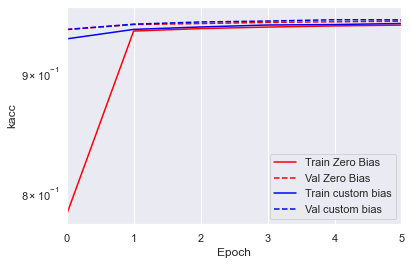

In [60]:
plot_loss(zero_bias_history, "Zero Bias", 'Red', 'kacc')
plot_loss(careful_bias_history, "custom bias", 'Blue', 'kacc')

## Unopt model

In [61]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    xtrain,
    ytrain,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(xval, yval),
    verbose=0)

In [62]:
def plot_metrics(history):
    metrics =  ['loss', 'accuracy', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color='Blue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color='Red', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

    plt.legend()
    plt.tight_layout()

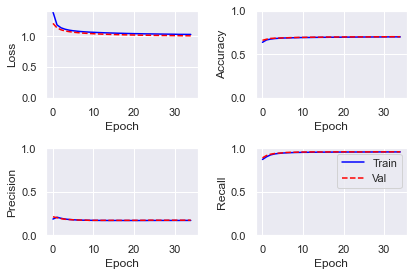

In [63]:
plot_metrics(baseline_history)

In [65]:
# pred = model.predict_classes(xval)

# use np.argmax instead of predict_classes (deprecated)
pred = np.argmax(model.predict(xval), axis=-1)

In [66]:
label_codes = pd.concat([tags, tags_coded],axis=1).drop_duplicates()
label_codes.columns= ["label","code"]
label_codes = label_codes.sort_values('code').reset_index(drop=True)

Normalized confusion matrix


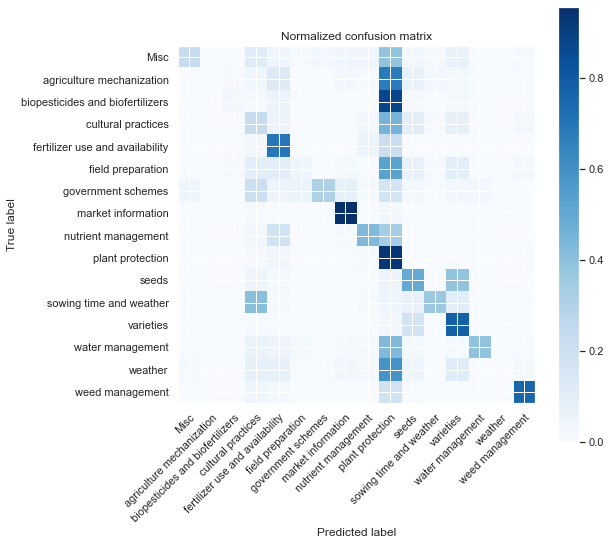

In [67]:
plt.figure(figsize=(8,8))
ax= plt.subplot(111)
ax = plot_confusion_matrix(tags_coded[test_ind], pred, classes=label_codes.label, normalize=True,
                      title='Normalized confusion matrix', axi=ax);

Normalized confusion matrix


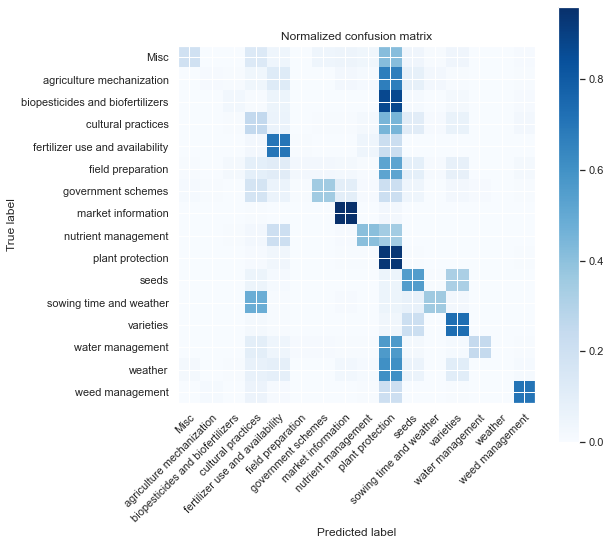

In [111]:
plt.figure(figsize=(8,8))
ax= plt.subplot(111)
ax = plot_confusion_matrix(tags_coded[test_ind], pred, classes=label_codes.label, normalize=True,
                      title='Normalized confusion matrix', axi=ax);

In [68]:
f1_score(y_true=tags_coded, y_pred=np.argmax(model.predict(wv_features), axis=-1), average='weighted')

0.6536867348173824

In [69]:
dump_keras(model,baseline_history, "./models/baseline")

INFO:tensorflow:Assets written to: ./models/baseline.model/assets


## With class weights

In [70]:
import numpy as np
import math

def create_class_weight(labels,mu=0.15):
    total = labels.sum()
    keys = labels.keys()
    cw = dict()
    
    # make a cap
    mean_score = np.round(np.mean([math.log(mu*total/float(labels[i])) for i in keys]), 2)

    for key in keys:
        score = math.log(mu*total/float(labels[key] ))
        cw[key] = round(score, 2) if score < mean_score else 1.0 #round(score,2)  if score < mean_score else mean_score

    return cw

In [71]:
# gentle reweighting
weights = create_class_weight(tags_coded.value_counts(), 1)
weights

{9: 0.78,
 4: 2.26,
 7: 2.34,
 12: 2.9,
 3: 2.91,
 8: 3.01,
 2: 3.02,
 10: 3.03,
 5: 3.62,
 1: 1.0,
 14: 1.0,
 0: 1.0,
 15: 1.0,
 6: 1.0,
 11: 1.0,
 13: 1.0}

In [72]:
weight_array = np.array([weights[i] for i in range(len(weights.keys()))])

In [73]:
try:
    weighted_model, weighted_history = load_keras("./models/weighted_model")
except:
    weighted_model=False

In [ ]:
# not sure where to find this
pd.read_csv("./tuning_paddy/12162019.csv").sort_values('val_acc', ascending=False).head(3)

In [75]:
keras.backend.clear_session()

In [76]:
METRICS = make_metrics()

In [77]:
def make_optimal_model(metrics = METRICS, output_bias=None):
    
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    
    model = keras.Sequential([
          keras.layers.Dense(
              64, activation='sigmoid',
              input_shape=(100,)),
          keras.layers.Dropout(0.3),
          keras.layers.Dense(16, activation='sigmoid'),
          keras.layers.Dense(num_class, activation='sigmoid',
                             bias_initializer=output_bias),
      ])

    model.compile(
        optimizer=keras.optimizers.Nadam(),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=metrics)

    return model

In [78]:
weighted_model = make_optimal_model(METRICS, output_bias=initial_bias.bias.values)
#weighted_model.load_weights(initial_weights)

In [79]:
xtrain.shape, ytrain.shape

((403716, 100), (403716, 16))

In [80]:
weighted_history = weighted_model.fit(
    xtrain,
    ytrain,
    batch_size=16,
    epochs=50,
    callbacks = [early_stopping],
    validation_data=(xval, yval),
    class_weight=weights,
    verbose=0)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping


In [81]:
weighted_history

In [82]:
dump_keras(weighted_model, weighted_history, "./models/weighted_model")

INFO:tensorflow:Assets written to: ./models/weighted_model.model/assets


In [84]:
# pred = weighted_model.predict_classes(xval)
pred = np.argmax(model.predict(xval), axis=-1)

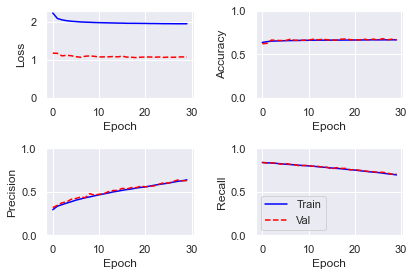

In [85]:
plot_metrics(weighted_history)

Normalized confusion matrix


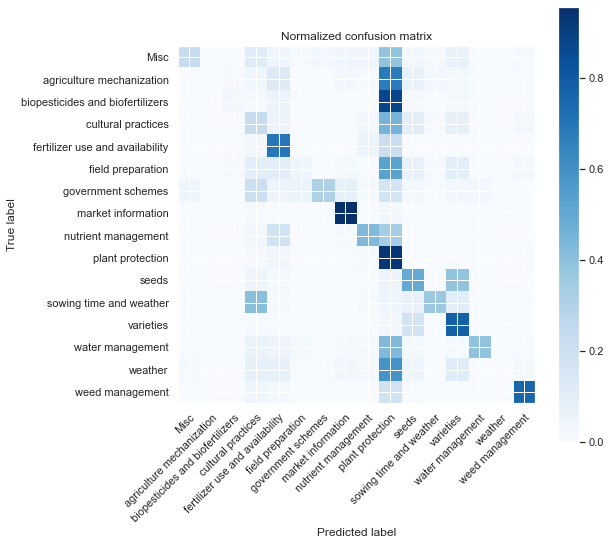

In [86]:
plt.figure(figsize=(8,8))
ax= plt.subplot(111)
ax = plot_confusion_matrix(tags_coded[test_ind], pred, classes=label_codes.label, normalize=True,
                      title='Normalized confusion matrix', axi=ax);

In [87]:
# newlabels = weighted_model.predict_classes(wv_features)
newlabels = np.argmax(model.predict(wv_features), axis=-1)

In [88]:
print("f1w", f1_score(y_true=tags_coded, y_pred=newlabels, average='weighted') )
print("f1w", f1_score(y_true=tags_coded, y_pred=newlabels, average='macro') )

f1w 0.6536867348173824
f1w 0.41716281659374277


In [89]:
weighted_model.weights

[<tf.Variable 'dense/kernel:0' shape=(100, 64) dtype=float32, numpy=
 array([[-3.83460641e-01, -1.05414368e-01, -3.05521488e-01, ...,
         -2.45323277e+00,  7.63965368e-01,  1.58515167e+00],
        [ 3.88113767e-01,  1.52219021e+00,  3.90724391e-01, ...,
         -9.43389416e-01,  1.00956225e+00, -6.52289093e-01],
        [-1.14279157e-02, -1.00706279e+00,  9.94670868e-01, ...,
         -6.10976696e-01,  2.90484071e-01, -4.72699106e-01],
        ...,
        [-1.11219251e+00,  5.44487059e-01, -2.28606701e+00, ...,
         -1.44483149e+00, -2.64568496e+00, -1.13000520e-01],
        [ 3.08730570e-03, -8.71696889e-01, -2.07614616e-01, ...,
          1.05979466e+00, -4.11222517e-01, -2.58714914e+00],
        [-9.89179373e-01,  4.85275723e-02, -1.62773788e+00, ...,
          1.06409550e+00,  2.17306358e-03, -1.01131216e-01]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(64,) dtype=float32, numpy=
 array([-0.86549705, -1.3999497 , -0.37697077, -0.0534119 , -2.0918694 ,
        

In [90]:
label_codes.set_index(label_codes.code, inplace=True)

In [91]:
label_codes.loc[10]

label    seeds
code        10
Name: 10, dtype: object

In [92]:
# newlabel = weighted_model.predict_classes(wv_features)
newlabel = np.argmax(model.predict(wv_features), axis=-1)

In [93]:
newlabel = pd.DataFrame(newlabel, columns=['Labelcode'])

In [94]:
newlabel = label_codes.merge(newlabel, left_index=True, right_on='Labelcode', how='right')

In [95]:
d['newlabel'] = newlabel.label
d['oldlabel'] = tags #d['query_type']
d['updated'] = (d.newlabel == d.oldlabel )== False

In [96]:
d.head()[['query_text_raw','kcc_answer_raw','newlabel','oldlabel']]

,query_text_raw,kcc_answer_raw,newlabel,oldlabel
0,tell me mandi rate of cotton,??????????? ???? ??? ???????? ???? ?? ??? 3900 ????? ????? ??????? ???,market information,market information
1,tell me mandi rate of cotton,sojat road kapas american 3940,market information,market information
2,tell me mandi rate of cotton,beawar kapas american 3950,market information,market information
3,tell me market rate of cotton ?,market rate of cotton 3950 quental,market information,market information
4,tell me mandi rate of cotton,hanumangarh kapas american 3990,market information,market information


Scoring the "coherence" of topics is quite difficult here, as the data only have one topic per query. So let's instead examine a random subset:

In [97]:
samp = []
for i in d.newlabel.value_counts().head().index:
    samp.append( d.loc[(d.updated==True) & (d.oldlabel==i), ['query_text_raw','kcc_answer_raw', 'newlabel','oldlabel']].sample(5, random_state=4) )
samp = pd.concat(samp)

In [98]:
samp

,query_text_raw,kcc_answer_raw,newlabel,oldlabel
293293,ask about subcidy in tractor,suggested 45000 or 40%,cultural practices,plant protection
444937,how to control of weed in cotton?,spray of stomp 1.25 ltr in 200 ltr wateracre.,weed management,plant protection
273756,ask for cotton fertilizer,suggest:give urea fertilizer,fertilizer use and availability,plant protection
452333,information regarding fertilizer dose in cotton at sowing time ?,information regarding fertilizer dose in cotton at sowing time ?apply 20 kg urea 50 kg dap 40 kg mop and 10 kg zinc in cotton at sowing time .,fertilizer use and availability,plant protection
52811,farmer needs information regarding nutrient defficiency in cotton crop?,use recommended dose of mgso4 (magnesium sulfate)5070 gram per pump,nutrient management,plant protection
307202,ask about general information,all information provided thanks for calling in kisaan call center,cultural practices,fertilizer use and availability
172723,attack of white fly?,spray roger 15 ml15 liter of water(dimethoate)cheminova,plant protection,fertilizer use and availability
195931,tell me growth regulator use in cotton .,spray soluble npk 18:18:18 grade 10 gmltr water,nutrient management,fertilizer use and availability
314339,ask about gernal information,all information provided thanks for calling in kisan call centre,cultural practices,fertilizer use and availability
168022,spray for cotton?,spray 13:0:45 60gm microla 30ml 15 lit of water,plant protection,fertilizer use and availability


In [99]:
del samp, newlabel
del weighted_model, weighted_history
gc.collect()

67122

As another sense-check, we can see how the tags vary over time, we expect tags to cluster together with time:

Text(0.5, 1.0, 'cotton, original labels maharashtra')

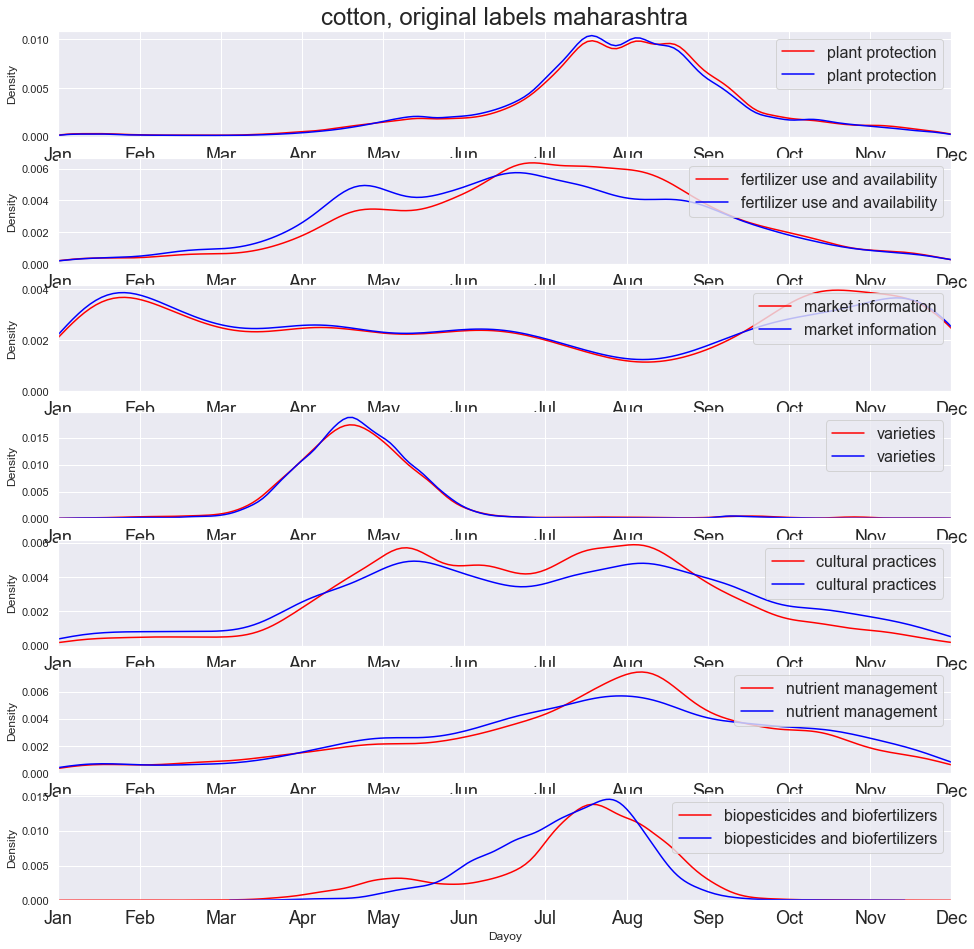

In [100]:
crop = crop_selected
d['Dayoy'] = pd.to_datetime(d.created_on).dt.dayofyear
target = d['query_type']
issues = target.value_counts().head(7).index.values  #['varieties' ,'weed management','fertilizer use and availability', 'plant protection','market information','biopesticides and biofertilizers','cultural practices']
state = d[d.crop==crop].state_name.value_counts().keys()[0]

fig, axs = plt.subplots(7,1, figsize=(16, 16), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=.15)
axs = axs.ravel()

for i in range(len(issues)):
    x = d[(d.crop==crop) & (target==issues[i]) & (d.state_name!=state)].Dayoy #& (df.state_name!=state)
    # sns.distplot(x, hist=False, label = issues[i],ax=axs[i], bins=365, color='red')
    sns.kdeplot(x, label=issues[i], ax=axs[i], color='red')
    
    x = d[(d.crop==crop) & (d.newlabel==issues[i]) & (d.state_name!=state)].Dayoy #& (df.state_name!=state)
    # sns.distplot(x, hist=False, label = issues[i],ax=axs[i], bins=365, color='blue') #new labels
    sns.kdeplot(x, label=issues[i], ax=axs[i], color='blue') #new labels
    axs[i].set_xlim(0,365)
    axs[i].legend(loc=1, fontsize=16)
    axs[i].set_xticks(np.linspace(0,365,12))
    axs[i].set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=18);

axs[0].set_title("{}, original labels {}".format(crop, state), size=24)

From the above it seems like our topics do indeed cluster by time.

Let's look at a 2D PCA plot to visualise topic clustering as another sense-check:

In [101]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(wv_features)

PCA(n_components=3)

In [102]:
print("Total variance explained with 2 components {} %".format(100*round(np.sum(pca.explained_variance_ratio_[0:2]),1)))

Total variance explained with 2 components 40.0 %


In [103]:
pca_vars = pca.transform(wv_features)

Text(0, 0.5, 'PC2')

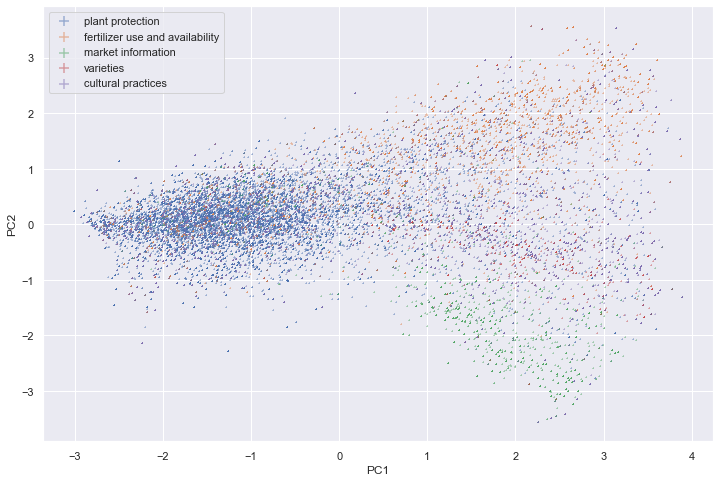

In [104]:
plt.figure(figsize=(12,8))
ax = plt.subplot(111)
for i in tags.value_counts().index[0:5]:
    ax.scatter(pca_vars[:,0][tags==i], pca_vars[:,1][tags==i], label=i, alpha=0.5, s=1, marker='+')
plt.legend(markerscale=10)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

From the above we can see reasonable seperation in 2 dimensions between the top 5 categories. This is especially clear for market information and fertilizer use.

We can visualise the entries with conflicting tags in the 2 principal components below:

In [105]:
matched = [tags[i]==d.newlabel[i] for i in range(len(tags))]
pca_data = pd.DataFrame({"newlabel":d.newlabel, "oldlabel":tags, "matched":matched, "pca1":pca_vars[:,0], "pca2":pca_vars[:,1]})

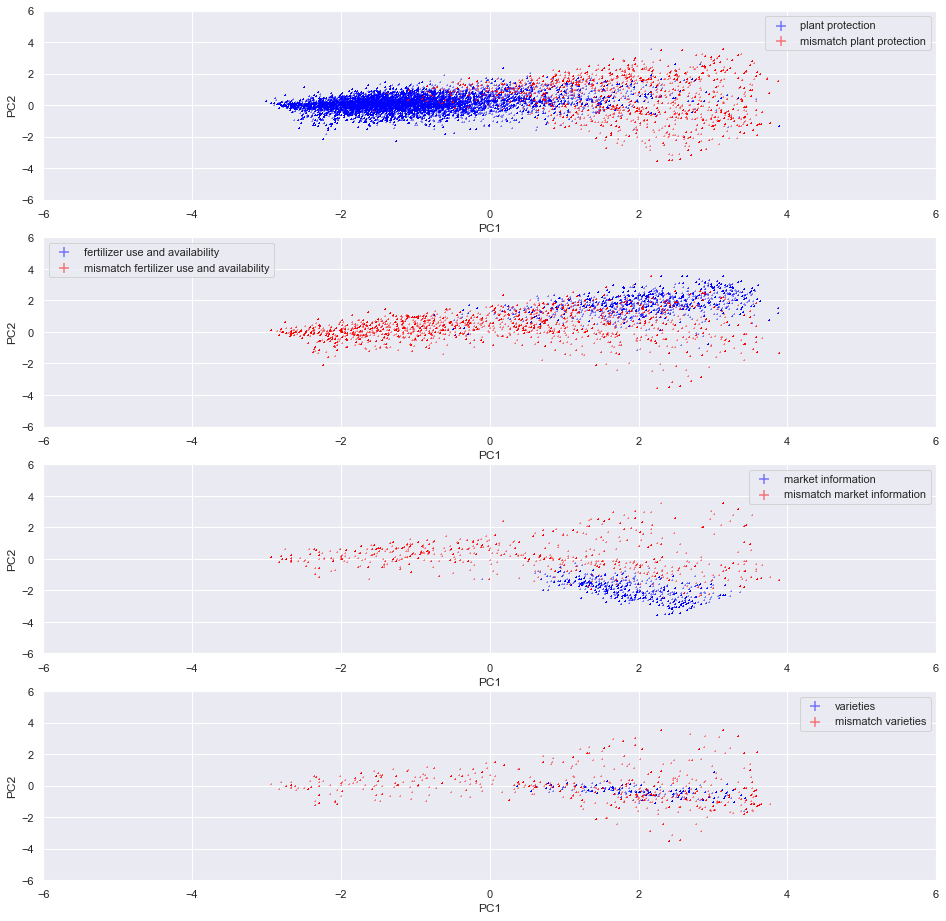

In [106]:
plt.figure(figsize=(16,16))

ax = plt.subplot(411)
sel = tags.value_counts().index[0]
ax.scatter(pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==True)].pca1 , pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==True)].pca2, label=sel, alpha=0.5, s=1, marker='+', color='blue')
ax.scatter(pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==False)].pca1 , pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==False)].pca2, label="mismatch {}".format(sel), alpha=0.5, s=1, marker='+', color='red')
ax.set_xlim(-6,6)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_ylim(-6,6)
plt.legend(markerscale=10)

ax = plt.subplot(412)
sel = tags.value_counts().index[1]
ax.scatter(pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==True)].pca1 , pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==True)].pca2, label=sel, alpha=0.5, s=1, marker='+', color='blue')
ax.scatter(pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==False)].pca1 , pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==False)].pca2, label="mismatch {}".format(sel), alpha=0.5, s=1, marker='+', color='red')
ax.set_xlim(-6,6)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_ylim(-6,6)
plt.legend(markerscale=10)

ax = plt.subplot(413)
sel = tags.value_counts().index[2]
ax.scatter(pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==True)].pca1 , pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==True)].pca2, label=sel, alpha=0.5, s=1, marker='+', color='blue')
ax.scatter(pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==False)].pca1 , pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==False)].pca2, label="mismatch {}".format(sel), alpha=0.5, s=1, marker='+', color='red')
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
plt.legend(markerscale=10)

ax = plt.subplot(414)
sel = tags.value_counts().index[3]
ax.scatter(pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==True)].pca1 , pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==True)].pca2, label=sel, alpha=0.5, s=1, marker='+', color='blue')
ax.scatter(pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==False)].pca1 , pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==False)].pca2, label="mismatch {}".format(sel), alpha=0.5, s=1, marker='+', color='red')
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
plt.legend(markerscale=10)

Notice that there does appear to be a clear clustering of each tag, and the "mismatches" fall outside of that cluster (above).

We can compare this with the new tags, and see how close the mismatches are to their new labels (below):

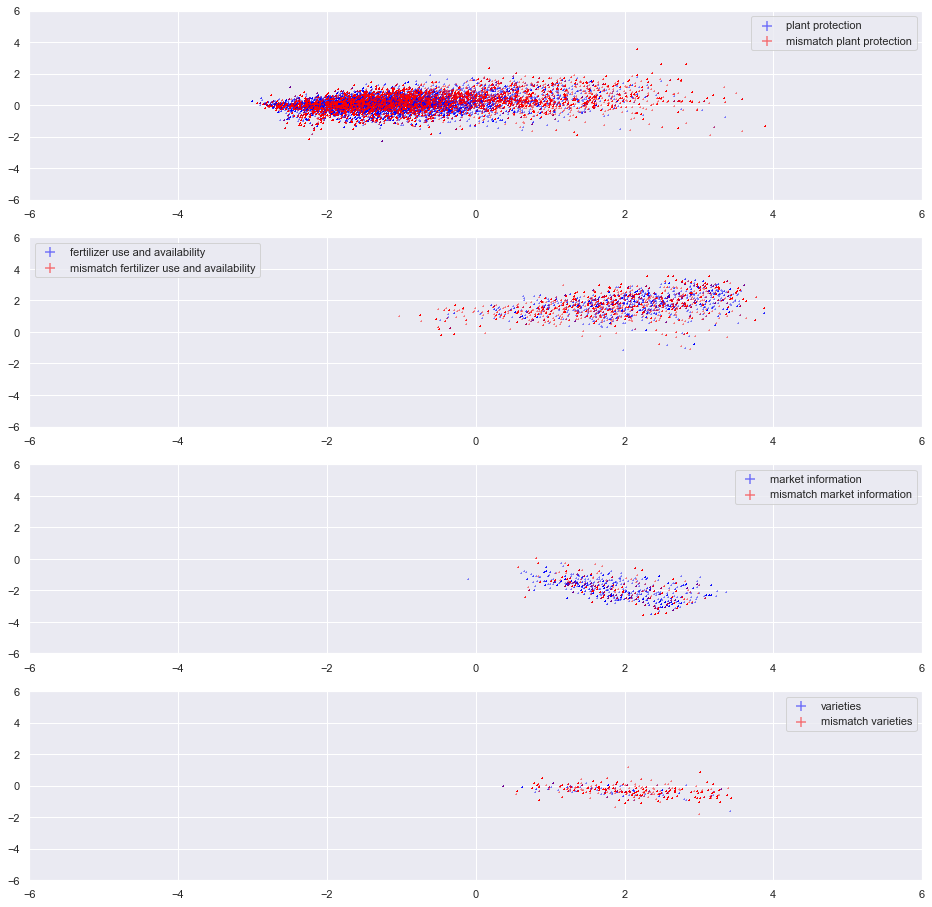

In [107]:
plt.figure(figsize=(16,16))

ax = plt.subplot(411)
sel = tags.value_counts().index[0]
ax.scatter(pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==True)].pca1 , pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==True)].pca2, label=sel, alpha=0.5, s=1, marker='+', color='blue')
ax.scatter(pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==False)].pca1 , pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==False)].pca2, label="mismatch {}".format(sel), alpha=0.5, s=1, marker='+', color='red')
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)
plt.legend(markerscale=10)

ax = plt.subplot(412)
sel = tags.value_counts().index[1]
ax.scatter(pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==True)].pca1 , pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==True)].pca2, label=sel, alpha=0.5, s=1, marker='+', color='blue')
ax.scatter(pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==False)].pca1 , pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==False)].pca2, label="mismatch {}".format(sel), alpha=0.5, s=1, marker='+', color='red')
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)
plt.legend(markerscale=10)

ax = plt.subplot(413)
sel = tags.value_counts().index[2]
ax.scatter(pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==True)].pca1 , pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==True)].pca2, label=sel, alpha=0.5, s=1, marker='+', color='blue')
ax.scatter(pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==False)].pca1 , pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==False)].pca2, label="mismatch {}".format(sel), alpha=0.5, s=1, marker='+', color='red')
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)
plt.legend(markerscale=10)

ax = plt.subplot(414)
sel = tags.value_counts().index[3]
ax.scatter(pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==True)].pca1 , pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==True)].pca2, label=sel, alpha=0.5, s=1, marker='+', color='blue')
ax.scatter(pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==False)].pca1 , pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==False)].pca2, label="mismatch {}".format(sel), alpha=0.5, s=1, marker='+', color='red')
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)
plt.legend(markerscale=10)

Side by side this is somewhat clearer:

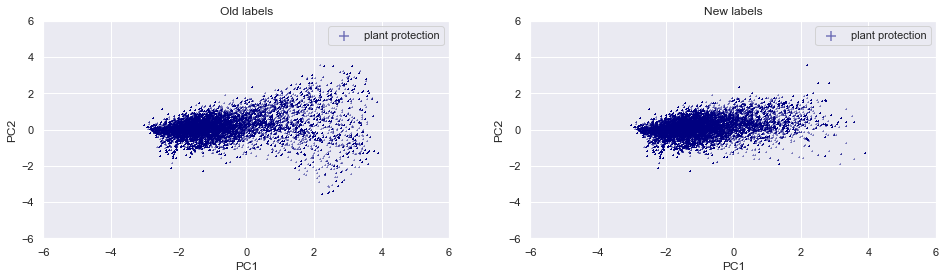

In [108]:
plt.figure(figsize=(16,4))


ax = plt.subplot(121)
sel = tags.value_counts().index[0]
ax.scatter(pca_data[(pca_data.oldlabel==sel)].pca1 , pca_data[(pca_data.oldlabel==sel)  ].pca2, label=sel, alpha=0.5, s=1, marker='+', color='navy')

ax.set_xlim(-6,6)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_ylim(-6,6)
ax.set_title("Old labels")
plt.legend(markerscale=10)

ax = plt.subplot(122)
sel = tags.value_counts().index[0]
ax.scatter(pca_data[(pca_data.newlabel==sel) ].pca1 , pca_data[(pca_data.newlabel==sel)].pca2, label=sel, alpha=0.5, s=1, marker='+', color='navy')
#ax.scatter(pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==False)].pca1 , pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==False)].pca2, alpha=0.5, s=1, marker='+', color='k')
ax.set_xlim(-6,6)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_ylim(-6,6)
ax.set_title("New labels")
plt.legend(markerscale=10)

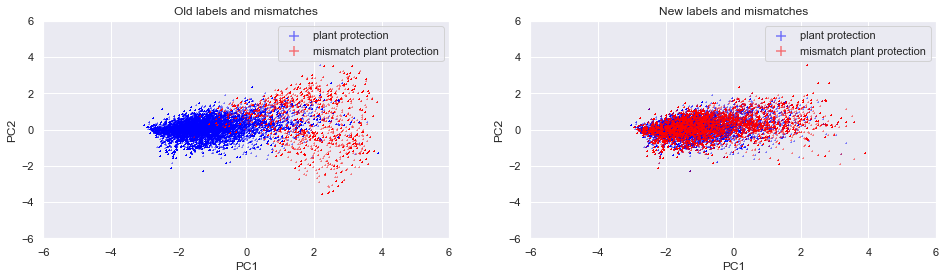

In [109]:
plt.figure(figsize=(16,4))


ax = plt.subplot(121)
sel = tags.value_counts().index[0]
ax.scatter(pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==True)].pca1 , pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==True)].pca2, label=sel, alpha=0.5, s=1, marker='+', color='blue')
ax.scatter(pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==False)].pca1 , pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==False)].pca2, label="mismatch {}".format(sel), alpha=0.5, s=1, marker='+', color='red')
ax.set_xlim(-6,6)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_ylim(-6,6)
ax.set_title("Old labels and mismatches")
plt.legend(markerscale=10)

ax = plt.subplot(122)
sel = tags.value_counts().index[0]
ax.scatter(pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==True)].pca1 , pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==True)].pca2, label=sel, alpha=0.5, s=1, marker='+', color='blue')
ax.scatter(pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==False)].pca1 , pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==False)].pca2, label="mismatch {}".format(sel), alpha=0.5, s=1, marker='+', color='red')
ax.set_xlim(-6,6)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_ylim(-6,6)
ax.set_title("New labels and mismatches")
plt.legend(markerscale=10)

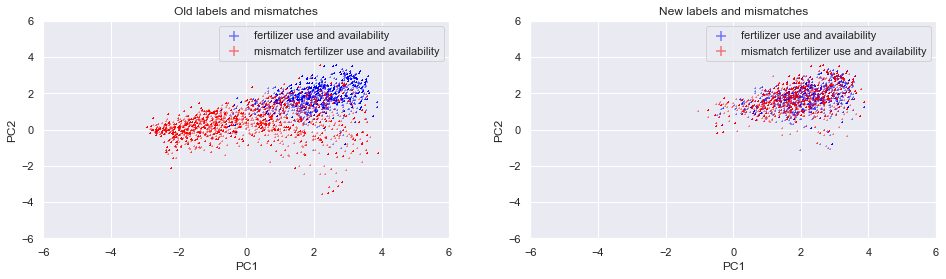

In [110]:
plt.figure(figsize=(16,4))


ax = plt.subplot(121)
sel = tags.value_counts().index[1]
ax.scatter(pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==True)].pca1 , pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==True)].pca2, label=sel, alpha=0.5, s=1, marker='+', color='blue')
ax.scatter(pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==False)].pca1 , pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==False)].pca2, label="mismatch {}".format(sel), alpha=0.5, s=1, marker='+', color='red')
ax.set_xlim(-6,6)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_ylim(-6,6)
ax.set_title("Old labels and mismatches")
plt.legend(markerscale=10)

ax = plt.subplot(122)
sel = tags.value_counts().index[1]
ax.scatter(pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==True)].pca1 , pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==True)].pca2, label=sel, alpha=0.5, s=1, marker='+', color='blue')
ax.scatter(pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==False)].pca1 , pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==False)].pca2, label="mismatch {}".format(sel), alpha=0.5, s=1, marker='+', color='red')
ax.set_xlim(-6,6)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_ylim(-6,6)
ax.set_title("New labels and mismatches")
plt.legend(markerscale=10)

In [111]:
def total_spread(data_in, locs, sample=10000000):
    # using det of cov matrix to estimate dispersion of data
    xdata = data_in[locs]#[['pca1','pca2']]
    cov_xdata = np.cov(xdata, rowvar=False) #np.dot(xdata.head(sample).values.T, xdata.head(sample).values)
    #return np.sqrt( np.linalg.det(cov_xdata) )
    return  np.trace(cov_xdata)

In [112]:
oldvals = []
newvals = []

for i in tags.value_counts().index[0:10]:
    oldvals.append( total_spread(wv_features, pca_data.oldlabel==i) )
    newvals.append( total_spread(wv_features, pca_data.newlabel==i) )

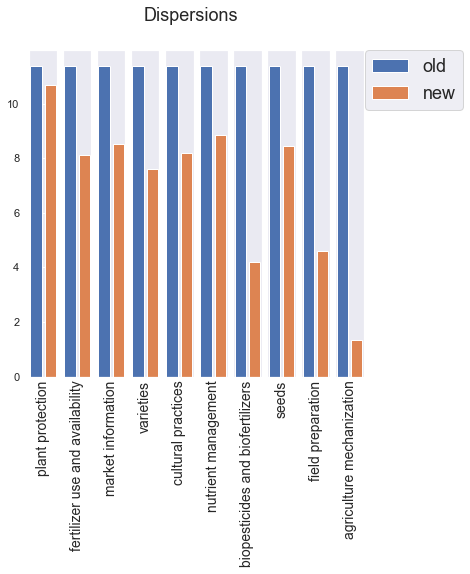

In [113]:
fig, axs = plt.subplots(1,10, figsize=(6, 6), facecolor='w', edgecolor='k')
plt.suptitle("Dispersions", size=18)
for i in range(len(oldvals)):
    axs[i].bar(0, oldvals[i], label="old")
    axs[i].bar(1, newvals[i], label="new")
    axs[i].set_xlabel(tags.value_counts().index[i], size=14, rotation=90)
    axs[i].set_xticks([])
    if i > 0:
        axs[i].set_yticks([])
        
        
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=18)

There is much more agreement with the new label distributions vs the old.

Overall this suggests that the new labels are superior to the old.

We also can view the above in 3 dimensions with the interactive plot below (output as a seperate html file to reduce the size of this notebook).

In [120]:
x = pd.DataFrame(pca_vars)
x.columns = ['c1','c2','c3']
x['tags'] = tags
x['size'] = 0.01

import plotly.express as px

fig = px.scatter_3d(x[x.tags.isin(list(tags.value_counts().index[0:5]))].sample(n=1000), x='c1', y='c2', z='c3',
              color='tags', opacity=0.5, size='size' )
# fig.show()
fig.write_html('3d_figure.html', auto_open=True)
# plt.plot(fig)

## Summary
We have built a simple topic prediction model based on word2vec features and a logistic regression model. We will save this data to S3 and use it to retrain the next version of P^3, if our retagging has been successful, then we expect a bump in P^3 performance.

## Save and Upload

In [121]:
newdf = d[['crop','created_on','latitude','longitude','state_name','district_name','newlabel','oldlabel']]
crops3 = str("_".join(newdf.crop.unique() )) + str("_")
newdf.to_pickle("./data/QnA_corrected.pkl")
print(crops3)

cotton_


In [124]:
newnewdf = d[['crop','created_on','query_text_raw','kcc_answer_raw','latitude','longitude','state_name','district_name','newlabel','oldlabel']]
newnewdf.to_csv('./QnA_corrected.csv', sep='\t')

In [122]:
d.head

<bound method NDFrame.head of           crop          created_on latitude longitude  \
0       cotton 2014-12-04 08:37:49     26.4     72.48   
1       cotton 2014-12-04 15:54:13    26.64     74.03   
2       cotton 2014-12-04 17:38:16    27.59     76.82   
3       cotton 2014-12-05 09:05:19    27.22     74.19   
4       cotton 2014-12-05 11:55:56    25.44     74.58   
...        ...                 ...      ...       ...   
504640  cotton 2013-10-26 17:12:24     20.7     77.01   
504641  cotton 2013-10-26 17:12:40    19.88     75.34   
504642  cotton 2013-10-26 17:26:36    19.87     75.73   
504643  cotton 2014-12-03 10:38:17    25.97     75.15   
504644  cotton 2014-12-03 15:29:04    26.64     74.03   

                             query_type   state_name district_name  \
0                    market information    rajasthan       jodhpur   
1                    market information    rajasthan        nagaur   
2                    market information    rajasthan         alwar   
3    

In [179]:
os.system("jupyter nbconvert --to html topic_modelling.ipynb")

65280

In [181]:
sys.exit

<function sys.exit(status=None, /)>